In [51]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [52]:
data = pd.read_csv('../data/cleaned_movies_no_outliers.csv')
threshold = 2.5
data['is_profitable'] = data['worldwide'] > threshold * data['budget']
data.drop(columns=['worldwide', 'domestic', 'international'], inplace=True)
data = data.select_dtypes(include=[np.number, np.bool_])

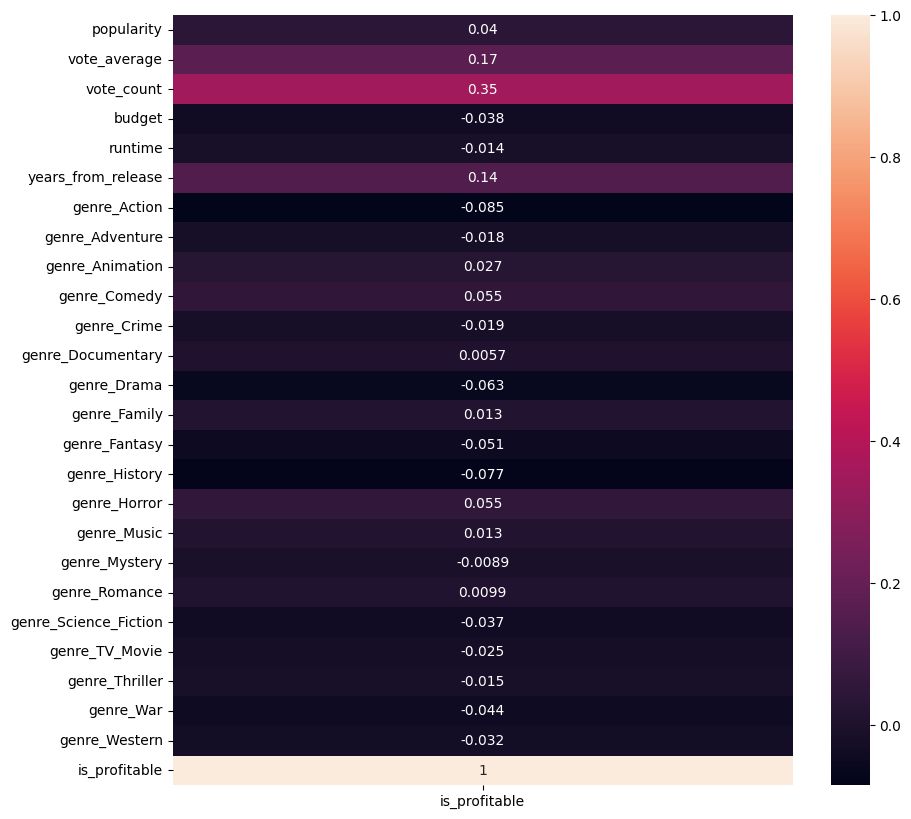

In [53]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr()[['is_profitable']], annot=True)
plt.show()

In [54]:
data = data.sample(frac=1, random_state=0) 
data

,popularity,vote_average,vote_count,budget,runtime,years_from_release,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,...,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science_Fiction,genre_TV_Movie,genre_Thriller,genre_War,genre_Western,is_profitable
124,189.475,6.660,3199,17000000,115,2,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
2304,25.373,6.500,2346,70000000,112,31,True,True,False,False,...,False,False,False,False,False,False,True,False,False,True
1428,24.910,6.100,2119,120000000,99,6,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1964,23.534,5.849,2251,18000000,101,29,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1727,31.635,6.187,6885,18000000,97,10,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,44.765,6.900,2289,75000000,121,21,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1731,31.604,7.400,2063,17000000,103,33,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
763,75.839,7.100,9983,183000000,127,5,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True
835,69.212,8.100,3789,2800000,131,21,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [55]:
split_points = [0.6, 0.8]
train = data.iloc[:int(split_points[0]*len(data))]
valid = data.iloc[int(split_points[0]*len(data)):int(split_points[1]*len(data))]
test = data.iloc[int(split_points[1]*len(data)):]

In [56]:
train_X = train.drop(columns=['is_profitable'])
train_y = train['is_profitable']
valid_X = valid.drop(columns=['is_profitable'])
valid_y = valid['is_profitable']
test_X = test.drop(columns=['is_profitable'])
test_y = test['is_profitable']

In [57]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

logreg = LogisticRegression(max_iter=2000, random_state=42)
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(train_X, train_y)

best_params = grid_search.best_params_
best_lr = grid_search.best_estimator_
print("Best Parameters:", best_params)
pred_y_valid = best_lr.predict(valid_X)
accuracy = accuracy_score(valid_y, pred_y_valid)
print("Test Accuracy On Validation Dataset:: ", accuracy)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Test Accuracy On Validation Dataset::  0.720173535791757


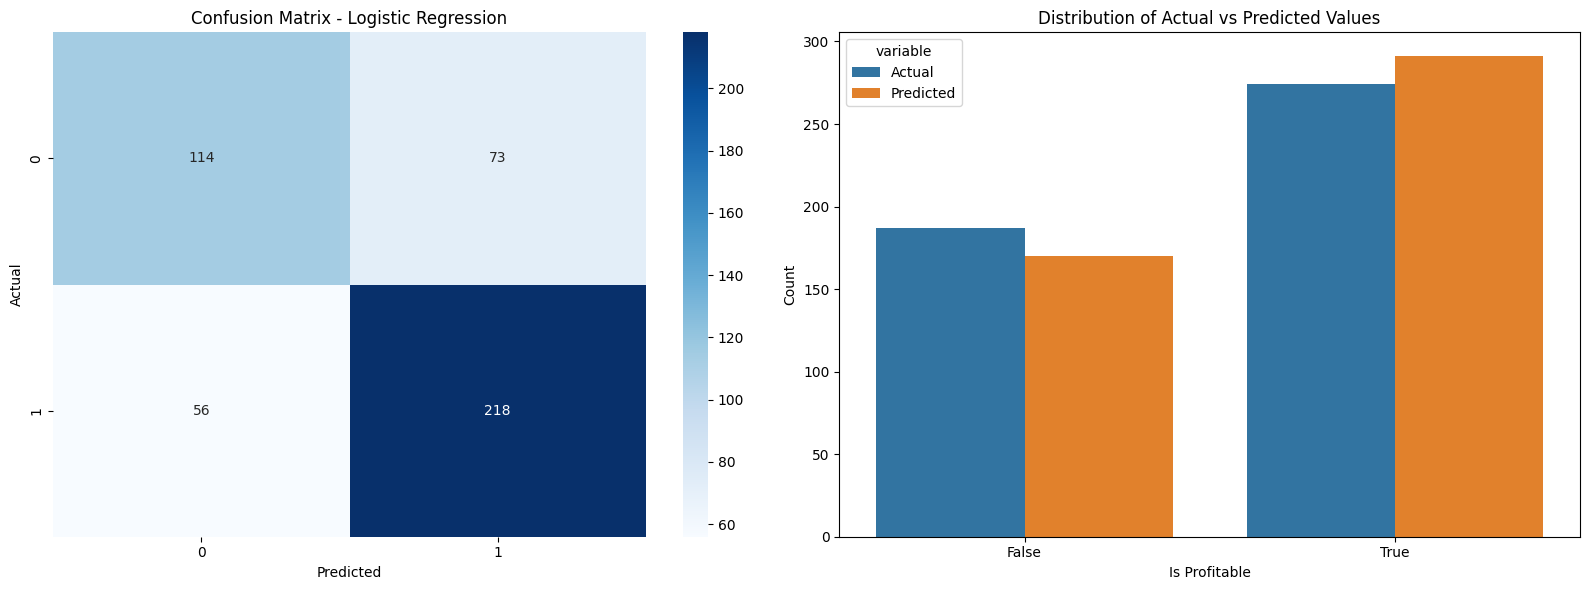

In [58]:
cm = confusion_matrix(valid_y, pred_y_valid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Confusion Matrix - Logistic Regression")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

comparison_df = pd.DataFrame({
    'Actual': valid_y,
    'Predicted': pred_y_valid
})
sns.countplot(data=pd.melt(comparison_df), 
              x='value', 
              hue='variable',
              ax=ax2)
ax2.set_title("Distribution of Actual vs Predicted Values")
ax2.set_xlabel("Is Profitable")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()



In [59]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'bootstrap': [True, False],
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(train_X, train_y)

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_
print("Best Parameters:", best_params)
pred_y_valid = best_rf.predict(valid_X)
accuracy = accuracy_score(valid_y, pred_y_valid)
print("Test Accuracy On Validation Dataset:", accuracy)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'bootstrap': True, 'max_depth': 30, 'n_estimators': 300}
Test Accuracy On Validation Dataset: 0.7527114967462039


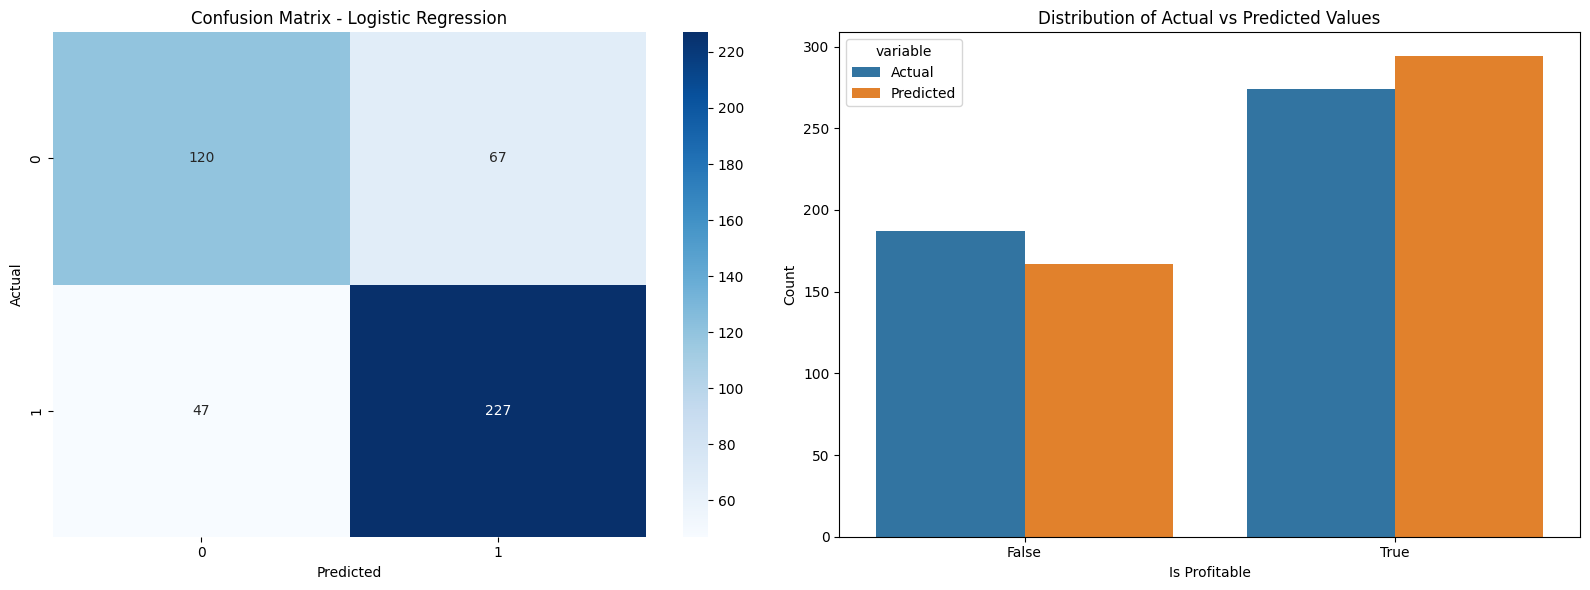

In [60]:
cm = confusion_matrix(valid_y, pred_y_valid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Confusion Matrix - Logistic Regression")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

comparison_df = pd.DataFrame({
    'Actual': valid_y,
    'Predicted': pred_y_valid
})
sns.countplot(data=pd.melt(comparison_df), 
              x='value', 
              hue='variable',
              ax=ax2)
ax2.set_title("Distribution of Actual vs Predicted Values")
ax2.set_xlabel("Is Profitable")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()



In [61]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
}

gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(train_X, train_y)

best_params = grid_search.best_params_
best_gb = grid_search.best_estimator_
print("Best Parameters:", best_params)
pred_y_valid = best_gb.predict(valid_X)
accuracy = accuracy_score(valid_y, pred_y_valid)
print("Test Accuracy On Validation Dataset:", accuracy)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'learning_rate': 0.05, 'n_estimators': 100}
Test Accuracy On Validation Dataset: 0.7505422993492408


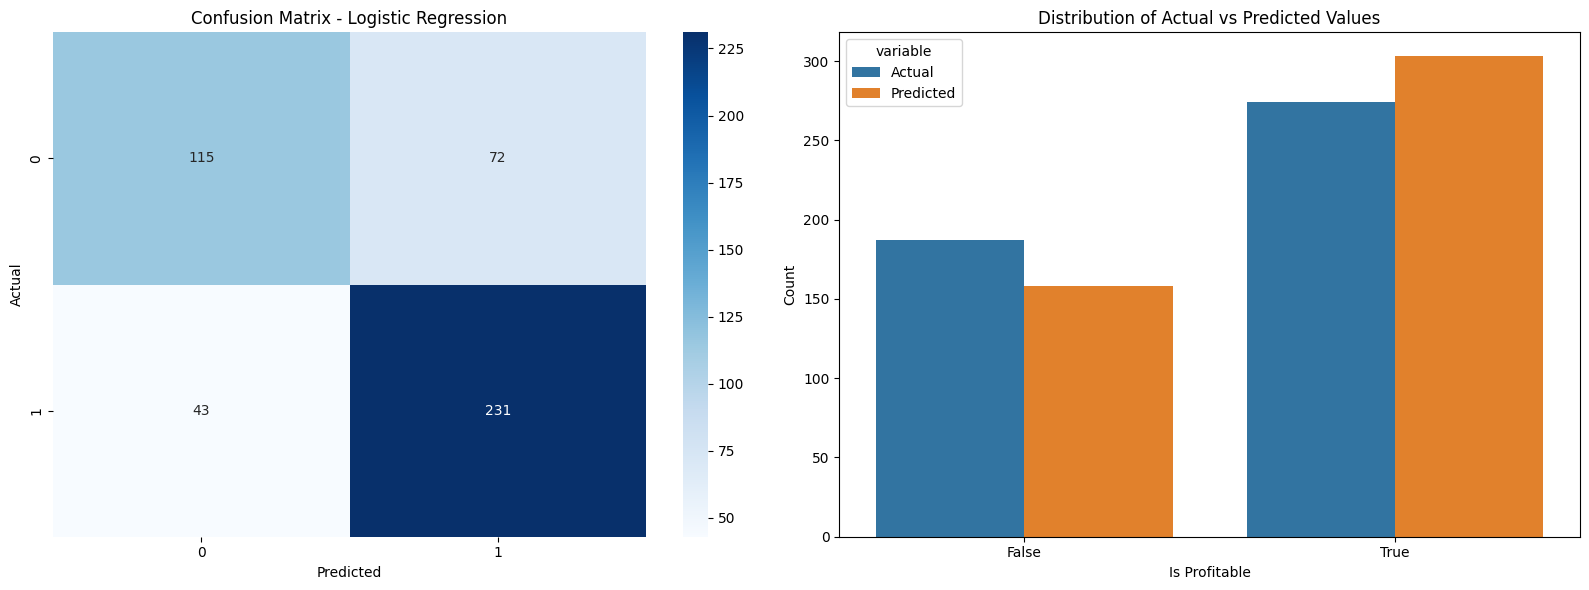

In [62]:
cm = confusion_matrix(valid_y, pred_y_valid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Confusion Matrix - Logistic Regression")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

comparison_df = pd.DataFrame({
    'Actual': valid_y,
    'Predicted': pred_y_valid
})
sns.countplot(data=pd.melt(comparison_df), 
              x='value', 
              hue='variable',
              ax=ax2)
ax2.set_title("Distribution of Actual vs Predicted Values")
ax2.set_xlabel("Is Profitable")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()



## Comparison 

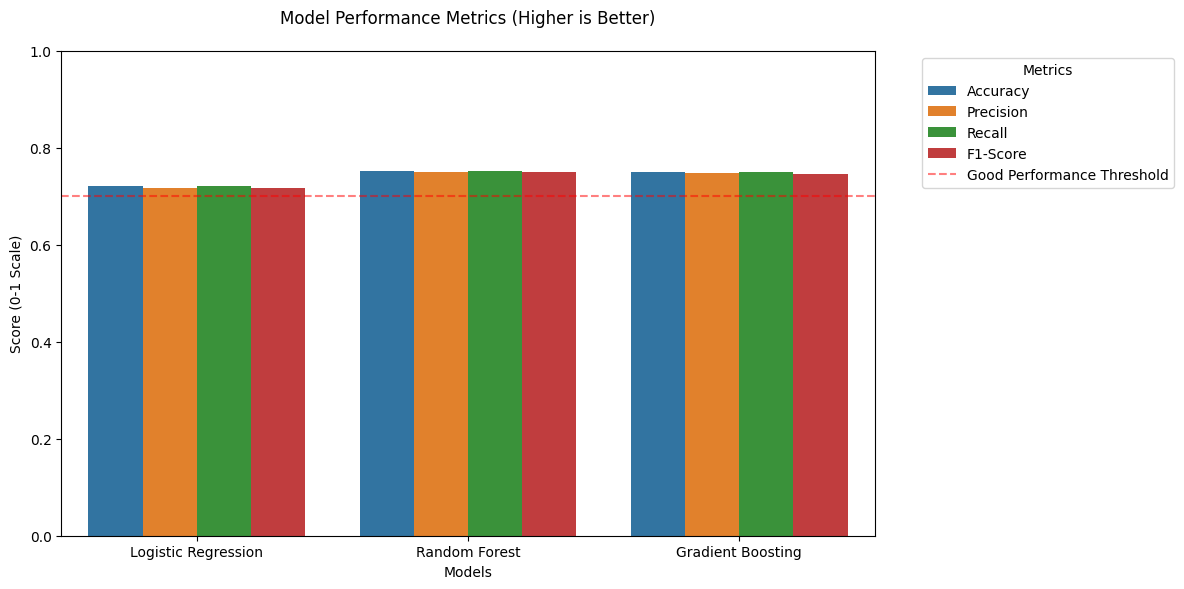

Best Model per Metric (Higher is Better):
Accuracy: Random Forest (0.7527)
Precision: Random Forest (0.7504)
Recall: Random Forest (0.7527)
F1-Score: Random Forest (0.7501)


In [63]:
models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'Gradient Boosting': best_gb
}

results = []
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for name, model in models.items():
    pred_y_valid = model.predict(valid_X)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(valid_y, pred_y_valid),  
        'Precision': precision_score(valid_y, pred_y_valid, average='weighted'),  
        'Recall': recall_score(valid_y, pred_y_valid, average='weighted'),  
        'F1-Score': f1_score(valid_y, pred_y_valid, average='weighted')  
    })

results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
results_melted = pd.melt(results_df, id_vars=['Model'], value_vars=metrics)

sns.barplot(data=results_melted, x='Model', y='value', hue='variable')
plt.title('Model Performance Metrics (Higher is Better)', pad=20)
plt.xlabel('Models')
plt.ylabel('Score (0-1 Scale)')

plt.axhline(y=0.7, color='r', linestyle='--', alpha=0.5, label='Good Performance Threshold')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1))
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

print("Best Model per Metric (Higher is Better):")
for metric in metrics:
    best_model = results_df.loc[results_df[metric].idxmax()]
    print(f"{metric}: {best_model['Model']} ({best_model[metric]:.4f})")

### Finding Best Model

In [64]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', None)  
])

param_grid = [
    {
        'classifier': [best_lr],
    },
    {
        'classifier': [best_rf],
    },
    {
        'classifier': [best_gb],
    },
]

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(train_X, train_y)

print("Best Model:", grid_search.best_params_['classifier'])
best_pipeline = grid_search.best_estimator_
best_pipeline.fit(train_X, train_y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Model: RandomForestClassifier(max_depth=30, n_estimators=300, random_state=42)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=30, n_estimators=300,
                                        random_state=42))])

### Best Model Evaluation on Test Dataset

Test Accuracy On Validation Dataset: 0.7527114967462039
Test Accuracy On Test Dataset: 0.7049891540130152


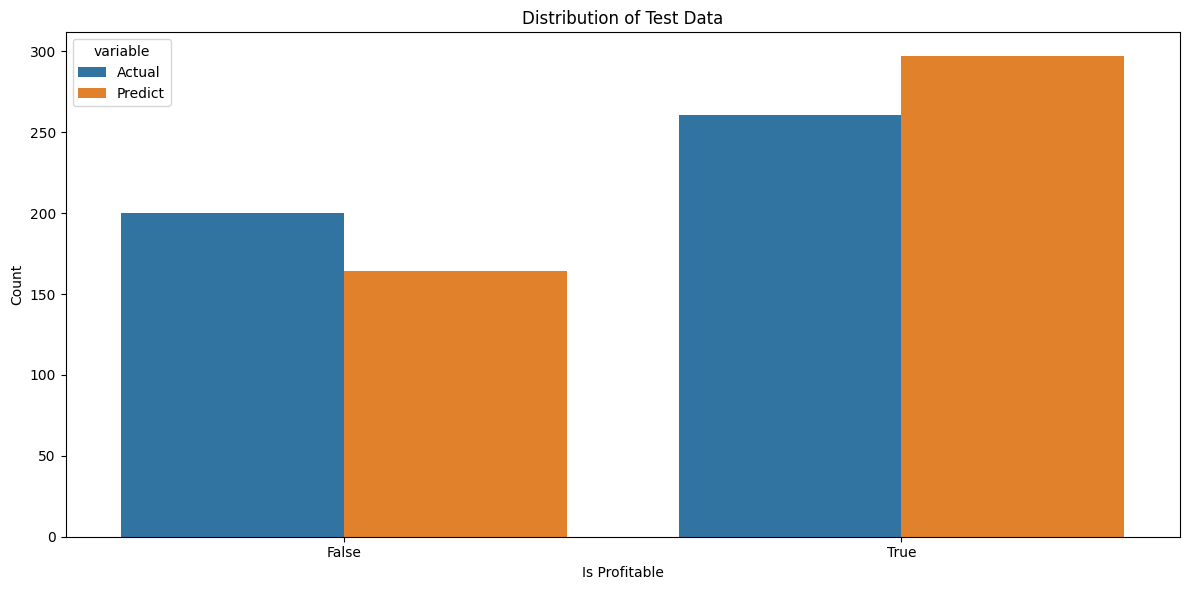

In [69]:
pred_y_test = best_pipeline.predict(test_X)
pred_y_valid = best_pipeline.predict(valid_X)
accuracy_valid = accuracy_score(valid_y, pred_y_valid)
accuracy_test = accuracy_score(test_y, pred_y_test)
print("Test Accuracy On Validation Dataset:", accuracy_valid)
print("Test Accuracy On Test Dataset:", accuracy_test)

plt.figure(figsize=(12, 6))
sns.countplot(data=pd.melt(pd.DataFrame({
    'Actual': test_y,
    'Predict': pred_y_test
})), x='value', hue='variable')

plt.title('Distribution of Test Data')
plt.xlabel('Is Profitable')
plt.ylabel('Count')

plt.tight_layout()
plt.show()